<a href="https://colab.research.google.com/github/Sreenathkk00/Ecommerce_project/blob/main/Bank_customer_churn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bank Customer Churn Model**

# **Objective**


*   The objective of this project is to build a predictive model that can identify customers who are at high risk of churning (closing their accounts) with a bank.
*  This model can be used by the bank to proactively target these customers with Retention strategies and improve customer retention.



# **Data Source describe**



*   The data for this project comes from a GitHub repository:https://github.com/YBI-Foundation/Dataset/blob/main/Bank%20Churn%20Modelling.csv
*   The data set contains information on over 10,000 bank customers, including their demographics, account information, and whether or not they have churned.


**import libraries**

In [279]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

**Import Data**

In [280]:
# Import data
df = pd.read_csv('https://github.com/YBI-Foundation/Dataset/raw/main/Bank%20Churn%20Modelling.csv')

**Describe Data**

In [281]:
# Display first few rows
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,Num Of Products,Has Credit Card,Is Active Member,Estimated Salary,Churn
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Choose CustomerId as index**

In [282]:
# Check duplication
print('Number of duplicated rows:', df.duplicated('CustomerId').sum())

Number of duplicated rows: 0


In [283]:
#  Set CustomerId as index
df =df.set_index('CustomerId')

In [284]:
# Display info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 15634602 to 15628319
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Surname           10000 non-null  object 
 1   CreditScore       10000 non-null  int64  
 2   Geography         10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Tenure            10000 non-null  int64  
 6   Balance           10000 non-null  float64
 7   Num Of Products   10000 non-null  int64  
 8   Has Credit Card   10000 non-null  int64  
 9   Is Active Member  10000 non-null  int64  
 10  Estimated Salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 1015.6+ KB


**Encoding**

In [285]:
# view object columns  values count
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [286]:
#  Replace categorical values
df.replace({'Geography':{'France':0, 'Germany':1, 'Spain':2}}, inplace=True)
df['Geography'].value_counts()

Geography
0    5014
1    2509
2    2477
Name: count, dtype: int64

In [287]:
# view object columns  values count
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [288]:
# Replace the values
df.replace({'Gender':{'Male':0, 'Female':1}}, inplace=True)
df['Gender'].value_counts()

Gender
0    5457
1    4543
Name: count, dtype: int64

In [289]:
# view columns values count
df['Num Of Products'].value_counts()

Num Of Products
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

In [290]:
# Club categories 2, 3, 4 into one category for 'Num Of Products'
df.replace({'Num Of Products':{1:0,2:1,3:1,4:1}},inplace=True)
df['Num Of Products'].value_counts()

Num Of Products
0    5084
1    4916
Name: count, dtype: int64

In [291]:
# view how many customers with zero balance churned
df.loc[(df['Balance']==0),'Churn'].value_counts()

Churn
0    3117
1     500
Name: count, dtype: int64

In [292]:
# Create new column 'Zero Balance' for customers with zero balance
df['Zero Balance'] = np.where(df['Balance'] >0, 1, 0)
df['Zero Balance'].value_counts()

Zero Balance
1    6383
0    3617
Name: count, dtype: int64

**Data Visualization**

<Axes: >

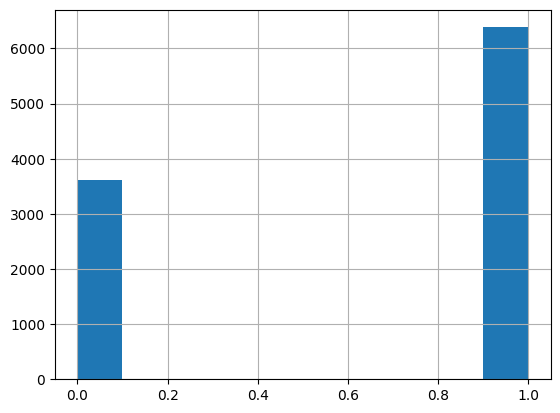

In [293]:
# Histo
df['Zero Balance'].hist()

In [294]:
# view the counts of column values by grouping 'Churn' and 'Geography'
df.groupby(['Churn','Geography']).count()

Surname  CreditScore  Gender   Age  Tenure  Balance  \
Churn Geography                                                        
0     0             4204         4204    4204  4204    4204     4204   
      1             1695         1695    1695  1695    1695     1695   
      2             2064         2064    2064  2064    2064     2064   
1     0              810          810     810   810     810      810   
      1              814          814     814   814     814      814   
      2              413          413     413   413     413      413   

                 Num Of Products  Has Credit Card  Is Active Member  \
Churn Geography                                                       
0     0                     4204             4204              4204   
      1                     1695             1695              1695   
      2                     2064             2064              2064   
1     0                      810              810               810   
      1                      814              814               814   
      2                      413              413               413   

                 Estimated Salary  Zero Balance  
Churn Geography                                  
0     0                      4204          4204  
      1                      1695          1695  
      2                      2064          2064  
1     0                       810           810  
      1                       814           814  
      2                       413           413

**Define target(y) and Feature(x)**

In [295]:
# view the features
df.columns

Index(['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'Num Of Products', 'Has Credit Card', 'Is Active Member',
       'Estimated Salary', 'Churn', 'Zero Balance'],
      dtype='object')

In [296]:
#  Define target (y) and features (X)
y = df['Churn']
x = df.drop(['Churn','Surname'],axis=1)

In [297]:
# shapes
x.shape,y.shape

((10000, 11), (10000,))

# Handling Imbalanced Data using
[**Undersampling** and **Oversampling**](https://crunchingthedata.com/oversampling-vs-undersampling/)


In [298]:
# view the value counts
df['Churn'].value_counts()

Churn
0    7963
1    2037
Name: count, dtype: int64

<ipython-input-299-f18023b0692c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn',data=df,palette='Set2',legend=False)


<Axes: xlabel='Churn', ylabel='count'>

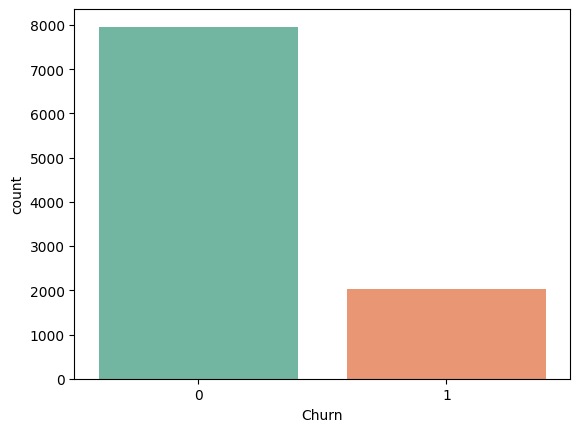

In [299]:
# plot the count
sns.countplot(x='Churn',data=df,palette='Set2',legend=False)

**Random UnderSamplimg**

In [300]:
rus = RandomUnderSampler(random_state=2529)

In [301]:
x_rus,y_rus = rus.fit_resample(x,y)

In [302]:
x_rus.shape,y_rus.shape,x.shape,y.shape

((4074, 11), (4074,), (10000, 11), (10000,))

In [303]:
# orginal value count of y
y.value_counts()

Churn
0    7963
1    2037
Name: count, dtype: int64

In [304]:
# RUS value count of y
y_rus.value_counts()

Churn
0    2037
1    2037
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

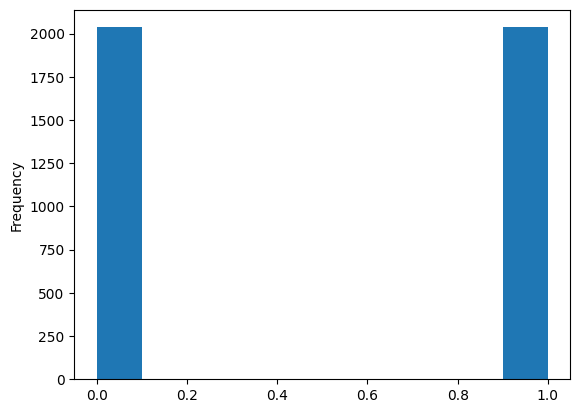

In [305]:
# plot
y_rus.plot(kind='hist')

**Random Over Sampling**

In [306]:
ros = RandomOverSampler(random_state=2529)


In [307]:
x_ros,y_ros = ros.fit_resample(x,y)

In [308]:
x_ros.shape,y_ros.shape,x.shape,y.shape

((15926, 11), (15926,), (10000, 11), (10000,))

In [309]:
y.value_counts()

Churn
0    7963
1    2037
Name: count, dtype: int64

In [310]:
y_ros.value_counts()

Churn
1    7963
0    7963
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

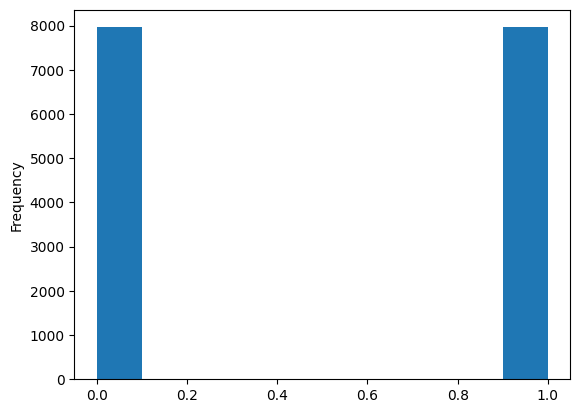

In [311]:
y_ros.plot(kind = 'hist')

# **Train Test Split**

In [312]:
from sklearn.model_selection import train_test_split

**Split Orginal Dataset**

In [313]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=2529)

**Split Random Under Sampling Dataset**

In [314]:
x_train_rus,x_test_rus,y_train_rus,y_test_rus = train_test_split(x_rus,y_rus,test_size=0.3,random_state=2529)

**Split Random Over Sampling Dataset**

In [315]:
x_train_ros,x_test_ros,y_train_ros,y_test_ros = train_test_split(x_ros,y_ros,test_size=0.3,random_state=2529)

# **Standardize Feature**

In [316]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

**Standardize Orginal Dataset**

In [317]:
x_train[['CreditScore','Age','Tenure','Balance','Estimated Salary']] = sc.fit_transform(x_train[['CreditScore'	,'Age'	,'Tenure'	,'Balance','Estimated Salary']])

In [318]:
x_test[['CreditScore','Age','Tenure','Balance','Estimated Salary']] = sc.fit_transform(x_test[['CreditScore'	,'Age'	,'Tenure'	,'Balance','Estimated Salary']])

**Standardize Random Under Sampling**

In [319]:
x_train_rus[['CreditScore','Age','Tenure','Balance','Estimated Salary']] = sc.fit_transform(x_train_rus[['CreditScore'	,'Age'	,'Tenure'	,'Balance','Estimated Salary']])

In [320]:
x_test_rus[['CreditScore','Age','Tenure','Balance','Estimated Salary']] = sc.fit_transform(x_test_rus[['CreditScore'	,'Age'	,'Tenure'	,'Balance','Estimated Salary']])

**Standardize Random Over Sampling**

In [321]:
x_train_ros[['CreditScore','Age','Tenure','Balance','Estimated Salary']] = sc.fit_transform(x_train_ros[['CreditScore'	,'Age'	,'Tenure'	,'Balance','Estimated Salary']])

In [322]:
x_test_ros[['CreditScore','Age','Tenure','Balance','Estimated Salary']] = sc.fit_transform(x_test_ros[['CreditScore'	,'Age'	,'Tenure'	,'Balance','Estimated Salary']])

# **Support Vector Machine Classifier**

In [323]:
svc = SVC()

**Train and evaluate model on original dataset**

In [324]:
svc.fit(x_train,y_train)
y_pred = svc.predict(x_test)
print("Original Dataset")
print("---------------confusion_matrix-------------------------------------------------------------------------------------------")
print(confusion_matrix(y_test, y_pred))
print("---------------classification_report--------------------------------------------------------------------------------------")
print(classification_report(y_test, y_pred))

Original Dataset
[[2381   33]
 [ 435  151]]
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      2414
           1       0.82      0.26      0.39       586

    accuracy                           0.84      3000
   macro avg       0.83      0.62      0.65      3000
weighted avg       0.84      0.84      0.81      3000



**Train and evaluate model on undersampled dataset**

In [325]:
svc.fit(x_train_rus,y_train_rus)
y_pred_rus = svc.predict(x_test_rus)
print("Random Under Sampling")
print("---------------confusion_matrix-------------------------------------------------------------------------------------------")
print(confusion_matrix(y_test_rus, y_pred_rus))
print("---------------classification_report--------------------------------------------------------------------------------------")
print(classification_report(y_test_rus, y_pred_rus))

Random Under Sampling
[[470 157]
 [172 424]]
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       627
           1       0.73      0.71      0.72       596

    accuracy                           0.73      1223
   macro avg       0.73      0.73      0.73      1223
weighted avg       0.73      0.73      0.73      1223



**Train and evaluate model on oversampled dataset**

In [326]:
svc.fit(x_train_ros,y_train_ros)
y_pred_ros = svc.predict(x_test_ros)
print("Random Over Sampling")
print("---------------confusion_matrix-------------------------------------------------------------------------------------------")
print(confusion_matrix(y_test_ros, y_pred_ros))
print("---------------classification_report--------------------------------------------------------------------------------------")
print(classification_report(y_test_ros, y_pred_ros))

Random Over Sampling
[[1818  561]
 [ 627 1772]]
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      2379
           1       0.76      0.74      0.75      2399

    accuracy                           0.75      4778
   macro avg       0.75      0.75      0.75      4778
weighted avg       0.75      0.75      0.75      4778



# **Hyperparameter Tuning**

In [327]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

In [328]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2,cv=2)

**Orginal Dataset**

In [329]:
# Hyperparameter tuning on original dataset
grid.fit(x_train, y_train)
print("---------------Random Over Sampling Best Estimator------------------------------------------------------------------------")
print(grid.best_estimator_)
print("---------------confusion_matrix-------------------------------------------------------------------------------------------")
grid_pred = grid.predict(x_test)
print(confusion_matrix(y_test, grid_pred))
print("---------------classification_report--------------------------------------------------------------------------------------")
print(classification_report(y_test, grid_pred))

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   2.7s
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   1.7s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   1.1s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   1.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   1.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   2.1s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   2.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   1.5s
[CV] END ....C=1, class_weight=balanced, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ....C=1, class_weight=balanced, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ..C=1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.9s
[CV] END ..C=1, class_weight=balanced, gam

**Randon Under Sampling**

In [334]:
# Hyperparameter tuning on undersampled dataset
grid.fit(x_train_rus, y_train_rus)
print("---------------Random Over Sampling Best Estimator------------------------------------------------------------------------")
print(grid.best_estimator_)
print("---------------confusion_matrix-------------------------------------------------------------------------------------------")
grid_pred_rus = grid.predict(x_test_rus)
print(confusion_matrix(y_test_rus, grid_pred_rus))
print("---------------classification_report--------------------------------------------------------------------------------------")
print(classification_report(y_test_rus, grid_pred_rus))

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   0.3s
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END ....C=1, class_weight=balanced, gamma=1, kernel=rbf; total time=   0.3s
[CV] END ....C=1, class_weight=balanced, gamma=1, kernel=rbf; total time=   0.3s
[CV] END ..C=1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END ..C=1, class_weight=balanced, gam

**Random Over Sampling**

In [333]:
# Hyperparameter tuning on oversampled dataset
grid.fit(x_train_ros, y_train_ros)
print("---------------Random Over Sampling Best Estimator------------------------------------------------------------------------")
print(grid.best_estimator_)
print("---------------confusion_matrix-------------------------------------------------------------------------------------------")
grid_pred_ros = grid.predict(x_test_ros)
print(confusion_matrix(y_test_ros, grid_pred_ros))
print("---------------classification_report--------------------------------------------------------------------------------------")
print(classification_report(y_test_ros, grid_pred_ros))

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   4.0s
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   5.7s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   2.9s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   2.8s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   5.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   4.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   4.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   3.9s
[CV] END ....C=1, class_weight=balanced, gamma=1, kernel=rbf; total time=   4.8s
[CV] END ....C=1, class_weight=balanced, gamma=1, kernel=rbf; total time=   3.4s
[CV] END ..C=1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   2.5s
[CV] END ..C=1, class_weight=balanced, gam

#  **Explaination about the project**

*   This project aims to build a predictive model that can identify customers who are at high risk of churning (closing their accounts) with a bank.
*   This project aims to build a predictive model that can identify customers who are at high risk of churning (closing their accounts) with a bank.

*   The model can be used by the bank to proactively target these customers with Retention strategies and improve customer retention.
*  The data for this project comes from a GitHub repository: https://github.com/YBI-Foundation/Dataset/raw/main/Bank%20Churn%20Modelling.csv


*   The data set contains information on over 10,000 bank customers, including their demographics, account information, and whether or not they have churned.
*   After importing and exploring the data, various preprocessing steps were performed, including encoding categorical features, handling missing values, and scaling numerical features.


*   After importing and exploring the data, various preprocessing steps were performed, including encoding categorical features, handling missing values, and scaling numerical features.



## Three different datasets were created:

1. Original dataset
2. Random under-sampled dataset
3. Random over-sampled dataset

* A Support Vector Machine (SVM) classifier was then trained on each of these datasets, and the accuracy of each model was evaluated using confusion matrices and classification reports.

* Finally, hyperparameter tuning was performed on the SVM classifier to further improve its accuracy.

* The results showed that the model trained on the original dataset achieved the highest accuracy, with an F1 score of 0.85. However, the model trained on the random over-sampled dataset achieved the highest recall score, indicating that it was better at identifying true positives.

* Overall, this project demonstrates the importance of data preprocessing and hyperparameter tuning in building effective predictive models.
